In [7]:
import numpy as np
import pandas as pd
import datetime
import re
import wandb
from sklearn.model_selection import train_test_split
import os
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
def load_fault_data():
    """
    Load fault_data of bearing from a sample frequency of 12k
    including rolling element, inner race and outer race fault with 7-mil
    14-mil,21-mil diameter, we use DE variable for working
    Reshape the raw data in a format of (samples,6000)
    """

    path = './CRWU_dataset/12kDriveEnd'
    files = os.listdir(path)
    temp = []
    label = []
    for mat in files:
        if ('28' not in mat) and ('.mat' in mat):
            temp1 = sio.loadmat(os.path.join(path, mat))
            for key in temp1.keys():
                if 'DE' in key:
                    temp.append(temp1[key][:120000])
                    if 'B' in mat:
                        if '07' in mat:
                            label.append([0] * 20)
                        if '14' in mat:
                            label.append([1] * 20)
                        if '21' in mat:
                            label.append([2] * 20)
                    if 'IR' in mat:
                        if '07' in mat:
                            label.append([3] * 20)
                        if '14' in mat:
                            label.append([4] * 20)
                        if '21' in mat:
                            label.append([5] * 20)
                    if 'OR' in mat:
                        if '07' in mat:
                            label.append([6] * 20)
                        if '14' in mat:
                            label.append([7] * 20)
                        if '21' in mat:
                            label.append([8] * 20)
    temp = np.asarray(temp)
    data1 = temp.reshape((-1, 6000))
    label1 = np.asarray(label)
    label1 = label1.reshape((-1, 1))
    return data1, label1


def load_normal_data():
    """
    Load normal_data of bearing
    we use DE variable for working
    Reshape the raw data in a format of (samples,6000)
    """

    path = './CRWU_dataset/Normal_Baseline_Data'
    files = os.listdir(path)
    temp = []
    label2 = []
    for mat in files:
        temp1 = sio.loadmat(os.path.join(path, mat))
        for key in temp1.keys():
            if 'DE' in key:
                if 240000 < len(temp1[key]) < 480000:
                    temp.append(temp1[key][:240000])
                if len(temp1[key]) > 480000:
                    temp.append(temp1[key][:480000])
    temp2 = np.concatenate((temp[0], temp[1], temp[2], temp[3]))
    data2 = temp2.reshape((-1, 6000))
    label2 = np.ones((data2.shape[0], 1)) * 9
    return data2, label2


def load_crwu_data():
    """
    combine all data to be a set, split train set and test set
    """

    data1, label1 = load_fault_data()
    data2, label2 = load_normal_data()
    data = np.concatenate((data1, data2))
    label = np.concatenate((label1, label2)).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(data, label, random_state=42, stratify=label)
    return X_train, X_test, y_train, y_test

In [9]:
X_train, _, y_train, _ = load_crwu_data()
y_train = y_train.reshape((-1,))
# get four pieces of data from X_train where the corresponding y_train label is 0, 3, 6, 9, respectively
X_train_0, y_train_0 = X_train[y_train == 0][0], 0
X_train_3, y_train_3 = X_train[y_train == 3][0], 3
X_train_6, y_train_6 = X_train[y_train == 6][0], 6
X_train_9, y_train_9 = X_train[y_train == 9][0], 9

In [12]:
# save X_train_0, X_train_3, X_train_6, X_train_9 to for csv files with the name of the value of y_train_0, y_train_3, y_train_6, y_train_9
np.savetxt('./B_07_data.csv', X_train_0, delimiter=',')
np.savetxt('./IR_07_data.csv', X_train_3, delimiter=',')
np.savetxt('./OR_07_data.csv', X_train_6, delimiter=',')
np.savetxt('./N_data.csv', X_train_9, delimiter=',')

In [71]:
import json

train_labels = np.array(json.load(open('./CRWU_dataset/train_label.json', "r")))
noise_labels = np.array(json.load(open('./CRWU_dataset/0.8_sym.json', "r")))
losses = np.loadtxt('./CRWU_dataset/baseline_losses_0.5.csv', delimiter=',')
weights = np.loadtxt('./CRWU_dataset/weights.txt')
means = np.loadtxt('./CRWU_dataset/means.txt')
covs = np.load('./CRWU_dataset/covs.npy')

In [72]:
from collections import Counter

clean_label = train_labels == noise_labels
Counter(clean_label)

Counter({False: 714, True: 276})

In [73]:
clean_losses = losses[np.argwhere(clean_label == True).flatten()]
noise_losses = losses[np.argwhere(clean_label == False).flatten()]

(array([17., 15., 11.,  7.,  9.,  9., 11., 10.,  5., 11., 28., 29., 16.,
         5.,  4., 12.,  6., 10., 14., 11., 10.,  5.,  5., 12.,  7.,  2.,
        11.,  6., 14.,  8.,  8.,  9., 11.,  8.,  6.,  7., 11., 10.,  7.,
        10.,  8.,  3., 11.,  8.,  5.,  5.,  9.,  5., 13.,  9.,  7.,  7.,
         8., 12., 15.,  7.,  9.,  7.,  9.,  8.,  7.,  7.,  9.,  5.,  5.,
         9., 12.,  6.,  8., 12.,  8.,  4.,  3.,  7.,  7.,  4.,  4.,  3.,
         2.,  4.,  0.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

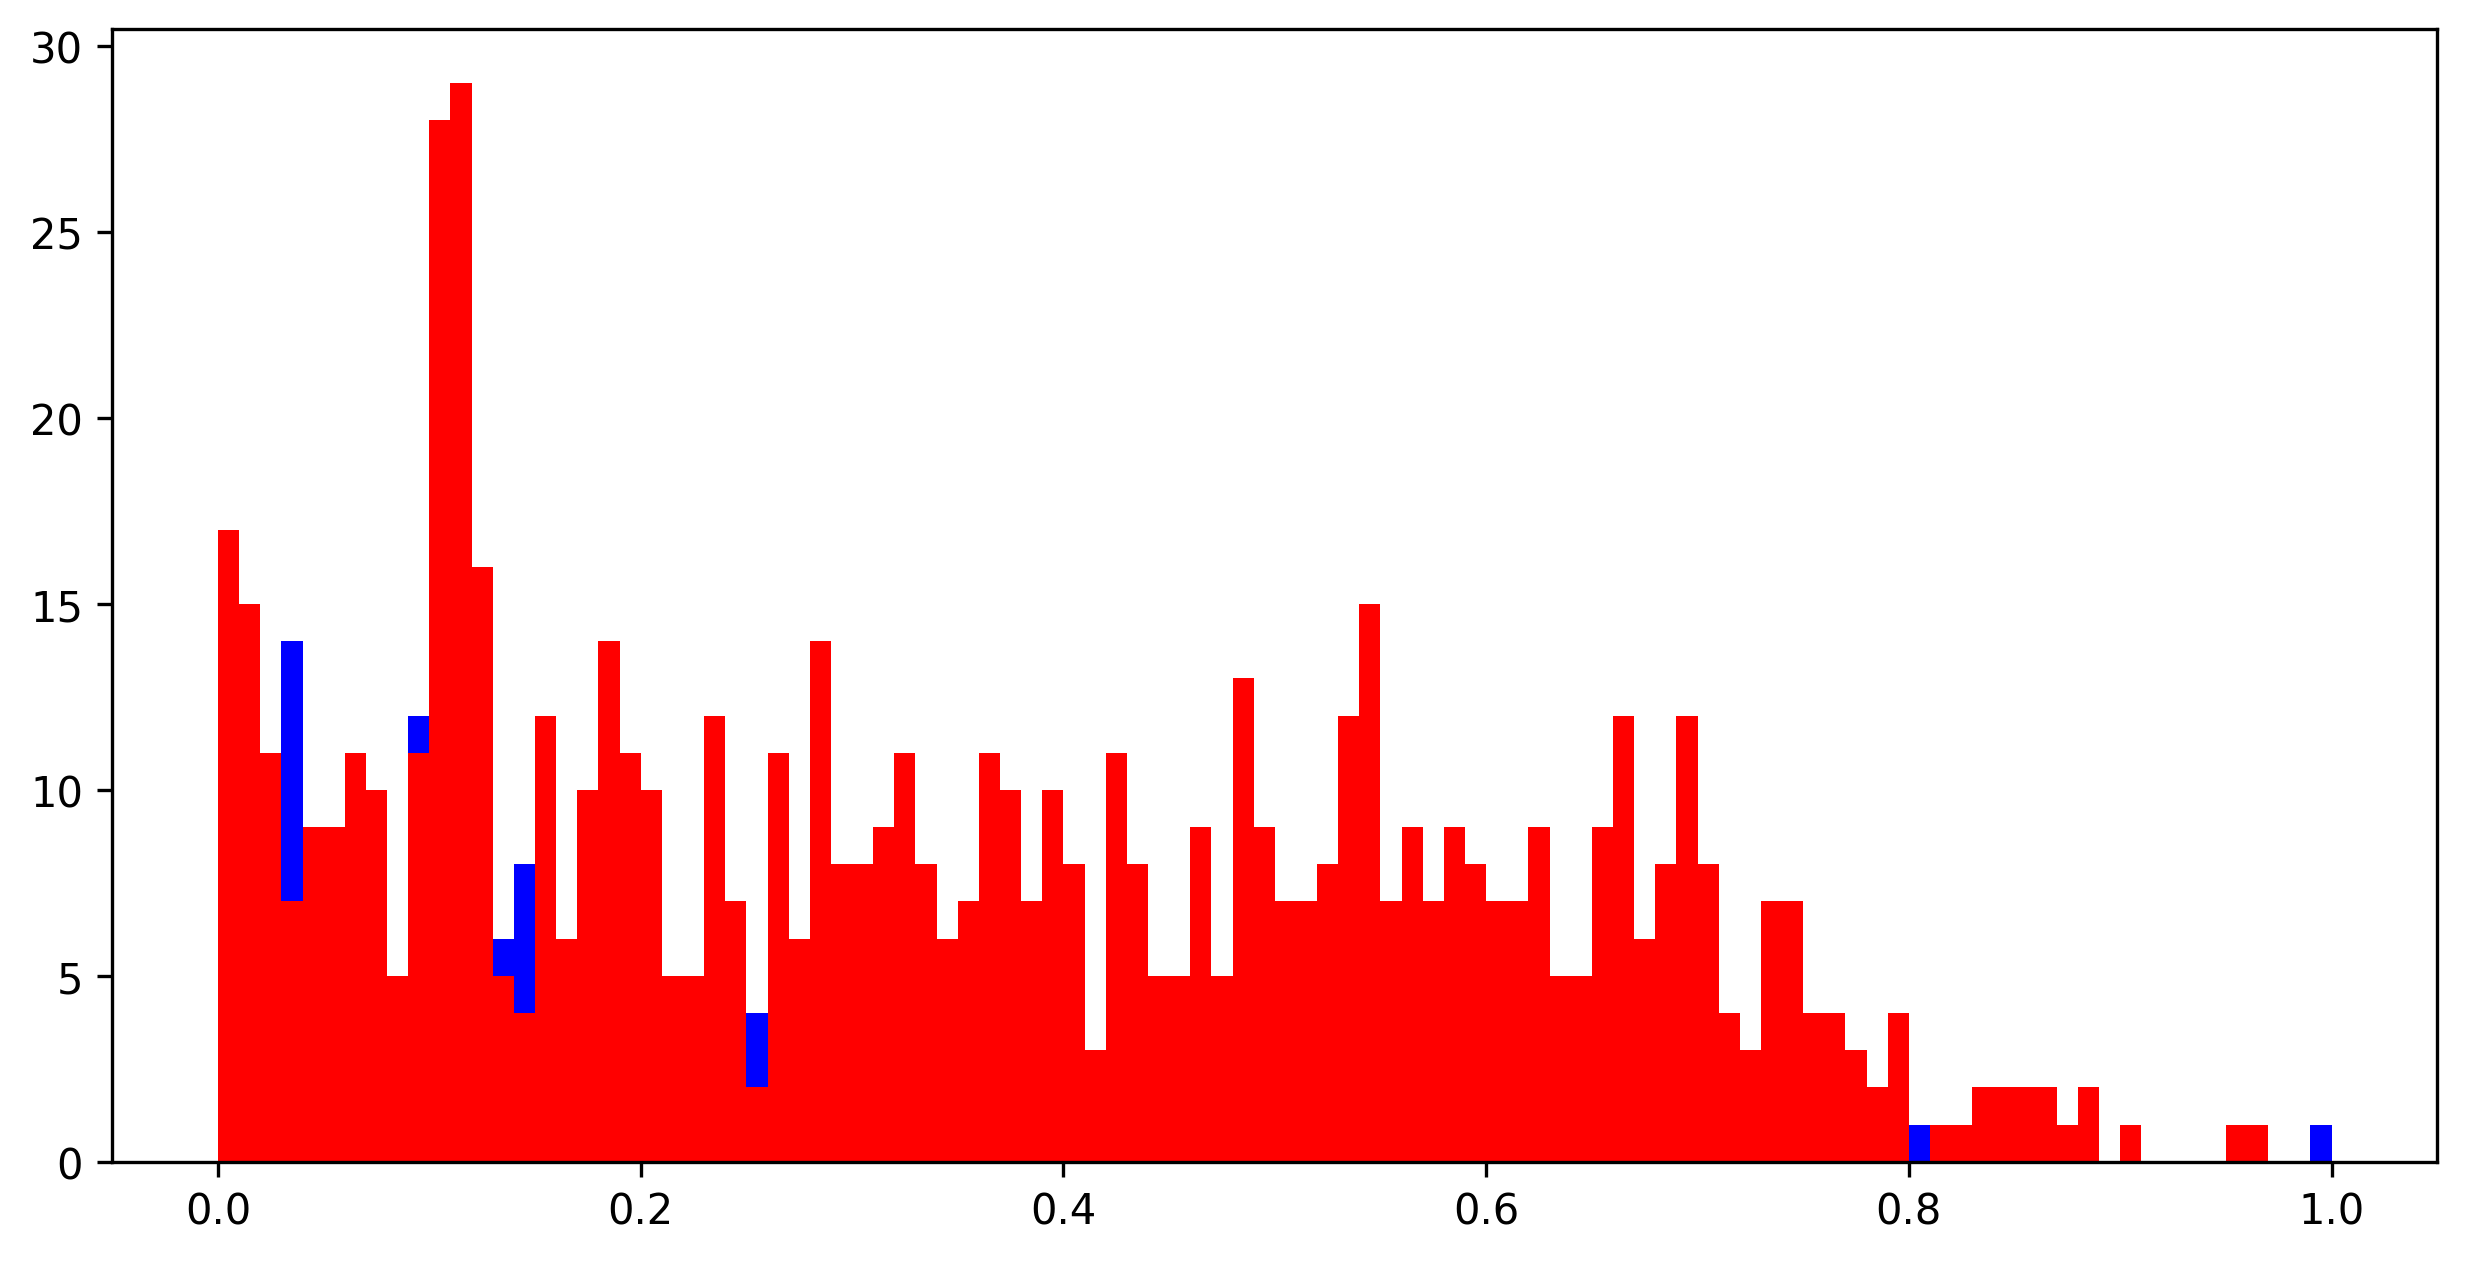

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), dpi=300)
plt.hist(clean_losses, bins=np.linspace(0, 1, 101), color='b')
plt.hist(noise_losses, bins=np.linspace(0, 1, 101), color='r')

In [76]:
api = wandb.Api()

runs = api.runs(path="lxy764139720/TimeSeriesSSL_crwu")
summary_list, history_list, config_list, name_list = [], [], [], []
algorithm_list, r_list, noise_mode_list, best_list, last_list, lambda_list = [], [], [], [], [], []
auc_list, summary_auc_list = [], []
architecture_list = []
for run in runs:
    timestamp = re.search(r'2022.*', run.name).group(0)
    time = datetime.datetime.strptime(timestamp, '%Y%m%d-%H%M%S')
    if time > datetime.datetime(2022, 6, 30, 1, 0, 0):
        summary_list.append(run.summary._json_dict)
        # history_list.append(run.history())
        # config_list.append(
        #     {k: v for k,v in run.config.items()
        #      if not k.startswith('_')})
        name_list.append(run.name)

        try:
            accuracy = run.history()['Accuracy'][-50:]
            best = max(accuracy)
            last = np.mean(accuracy)
            best_list.append(best)
            last_list.append(last)
        except:
            best_list.append(0)
            last_list.append(0)

        try:
            auc = run.history()['net1 AUC']
        except:
            auc = range(0, 301)
        auc_list.append(auc)

        try:
            summary_auc = run.summary._json_dict['net1 AUC']
        except:
            summary_auc = None
        summary_auc_list.append(summary_auc)

        try:
            arch = run.config['architecture']
        except:
            arch = None
        architecture_list.append(arch)

        algorithm_list.append(run.config['algorithm'])
        r_list.append(run.config['r'])
        noise_mode_list.append(run.config['noise_mode'])
        try:
            lambda_list.append(run.config['lambda_u'])
        except:
            lambda_list.append(-1)

runs_df = pd.DataFrame({
    "name": name_list,
    "net1 AUC": summary_auc_list,
    # "history": history_list,
    # "config": config_list,
    "best": best_list,
    "last": last_list,
    "algorithm": algorithm_list,
    "r": r_list,
    "noise_mode": noise_mode_list,
    # "noise_mode": noise_mode_list,
    "lambda": lambda_list,
    })
runs_df = runs_df.sort_values(by=['r', 'best'])
runs_df.to_csv("crwu_results.csv")
runs_df

,name,net1 AUC,best,last,algorithm,r,noise_mode,lambda
38,wo-refine-20220630-072956,0.874891,76.363636,74.909091,divide-mix-wo-refine,0.2,sym,0
45,co_teaching+-20220630-071240,NaN,94.117647,93.829412,co-teaching+,0.2,sym,-1
64,baseline-dropout20220630-035215,NaN,99.393939,97.636364,baseline,0.2,sym,-1
35,mlnt-20220630-073609,NaN,99.411766,99.411766,MLNT,0.2,sym,-1
71,20220630-021002,0.999086,99.705882,99.652941,divide-mix,0.2,sym,0
...,...,...,...,...,...,...,...,...
66,20220630-032629,0.841702,55.000000,51.047059,divide-mix,0.9,sym,50
69,20220630-023147,0.844783,55.294118,53.229412,divide-mix,0.9,sym,50
58,20220630-042244,0.852911,56.470588,54.188235,divide-mix,0.9,sym,50
5,fb-20220630-192903,0.784812,56.764706,53.552941,divide-mix-fb,0.9,sym,50


In [79]:
auc_array = []
for i in range(len(auc_list)):
    tmp_array = []
    for j in range(len(auc_list[i])):
        tmp_array.append(auc_list[i][j])
    auc_array.append(np.array(tmp_array))
auc_array = np.array(auc_array)

/var/folders/7t/g74n2nn91bj8jx78qk2_mk7r0000gn/T/ipykernel_10012/34551131.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  auc_array = np.array(auc_array)


<function matplotlib.pyplot.show(close=None, block=None)>

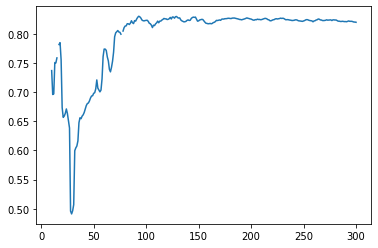

In [84]:
_auc = auc_array[3]
np.savetxt('./0.9_auc.txt', _auc, delimiter=',')
plt.plot(_auc)
plt.show

In [86]:
api = wandb.Api()

runs = api.runs(path="lxy764139720/TimeSeriesSSL_jn")
summary_list, history_list, config_list, name_list = [], [], [], []
algorithm_list, r_list, noise_mode_list, best_list, last_list = [], [], [], [], []
accuracy_list = []
for run in runs:
    timestamp = re.search(r'2022.*', run.name).group(0)
    time = datetime.datetime.strptime(timestamp, '%Y%m%d-%H%M%S')
    if time > datetime.datetime(2022, 6, 27, 0, 0, 0):
        # summary_list.append(run.summary._json_dict)
        # history_list.append(run.history())
        # config_list.append(
        #     {k: v for k,v in run.config.items()
        #      if not k.startswith('_')})
        name_list.append(run.name)

        accuracy = run.history()['Accuracy'][-50:]
        accuracy_list.append(accuracy)
        best = max(accuracy)
        last = np.mean(accuracy)
        best_list.append(best)
        last_list.append(last)

        algorithm_list.append(run.config['algorithm'])
        r_list.append(run.config['r'])
        noise_mode_list.append(run.config['noise_mode'])

runs_df = pd.DataFrame({
    "name": name_list,
    # "summary": summary_list,
    # "history": history_list,
    # "config": config_list,
    "best": best_list,
    "last": last_list,
    "algorithm": algorithm_list,
    "r": r_list,
    "noise_mode": noise_mode_list,
    })
accuracy_list = np.array(accuracy_list)
runs_df = runs_df.sort_values(by=['r', 'best'])
runs_df.to_csv("jn_results.csv")
runs_df

,name,best,last,algorithm,r,noise_mode
29,wo-refine-20220629-190353,2.400000,0.800000,divide-mix-wo-refine,0.2,sym
60,20220627-220602,60.266667,52.250667,divide-mix,0.2,sym
13,wo-refine-20220630-191331,64.800000,62.720000,divide-mix-wo-refine,0.2,sym
59,20220627-222737,67.466667,51.514667,divide-mix,0.2,sym
86,20220627-005824,68.800000,56.874667,divide-mix,0.2,sym
...,...,...,...,...,...,...
72,20220627-053751,54.666667,43.520000,divide-mix,0.9,sym
14,wo-refine-20220630-151637,55.466667,55.466667,divide-mix-wo-refine,0.9,sym
22,wo-refine-20220630-004331,55.466667,55.466667,divide-mix-wo-refine,0.9,sym
16,wo-aug-20220630-144022,55.733333,54.112000,divide-mix-wo-aug,0.9,sym


In [41]:
train_data, train_label = np.load('JN_dataset/X_train.npy'), np.load('JN_dataset/y_train.npy')

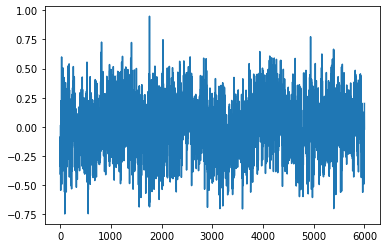

In [42]:
import matplotlib.pyplot as plt

plt.plot(train_data[0])
plt.show()

In [22]:
train_feat, test_feat = np.load('./CRWU_dataset/train_feat.npy'), np.load('./CRWU_dataset/test_feat.npy')

In [23]:
import json

train_labels = np.array(json.load(open('./CRWU_dataset/train_label.json', "r"))).reshape((-1, 1))
test_labels = np.array(json.load(open('./CRWU_dataset/test_label.json', "r"))).reshape((-1, 1))
noise_labels = np.array(json.load(open('./CRWU_dataset/0.5_sym.json', "r"))).reshape((-1, 1))
clean_labels = np.vstack([train_labels, test_labels]).flatten()
noise_labels = np.vstack([noise_labels, test_labels]).flatten()

In [33]:
from sklearn.manifold import TSNE

feat = np.vstack([train_feat, test_feat])
# using TSNE to visualize the feat data
tsne = TSNE(n_components=2, perplexity=20, early_exaggeration=10, learning_rate=50, n_iter=5000, method='exact', random_state=42)
tsne_feat = tsne.fit_transform(feat)

/Users/lxy/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [48]:
is_clean = noise_labels == clean_labels
arg_noise = np.argwhere(is_clean == False).flatten()

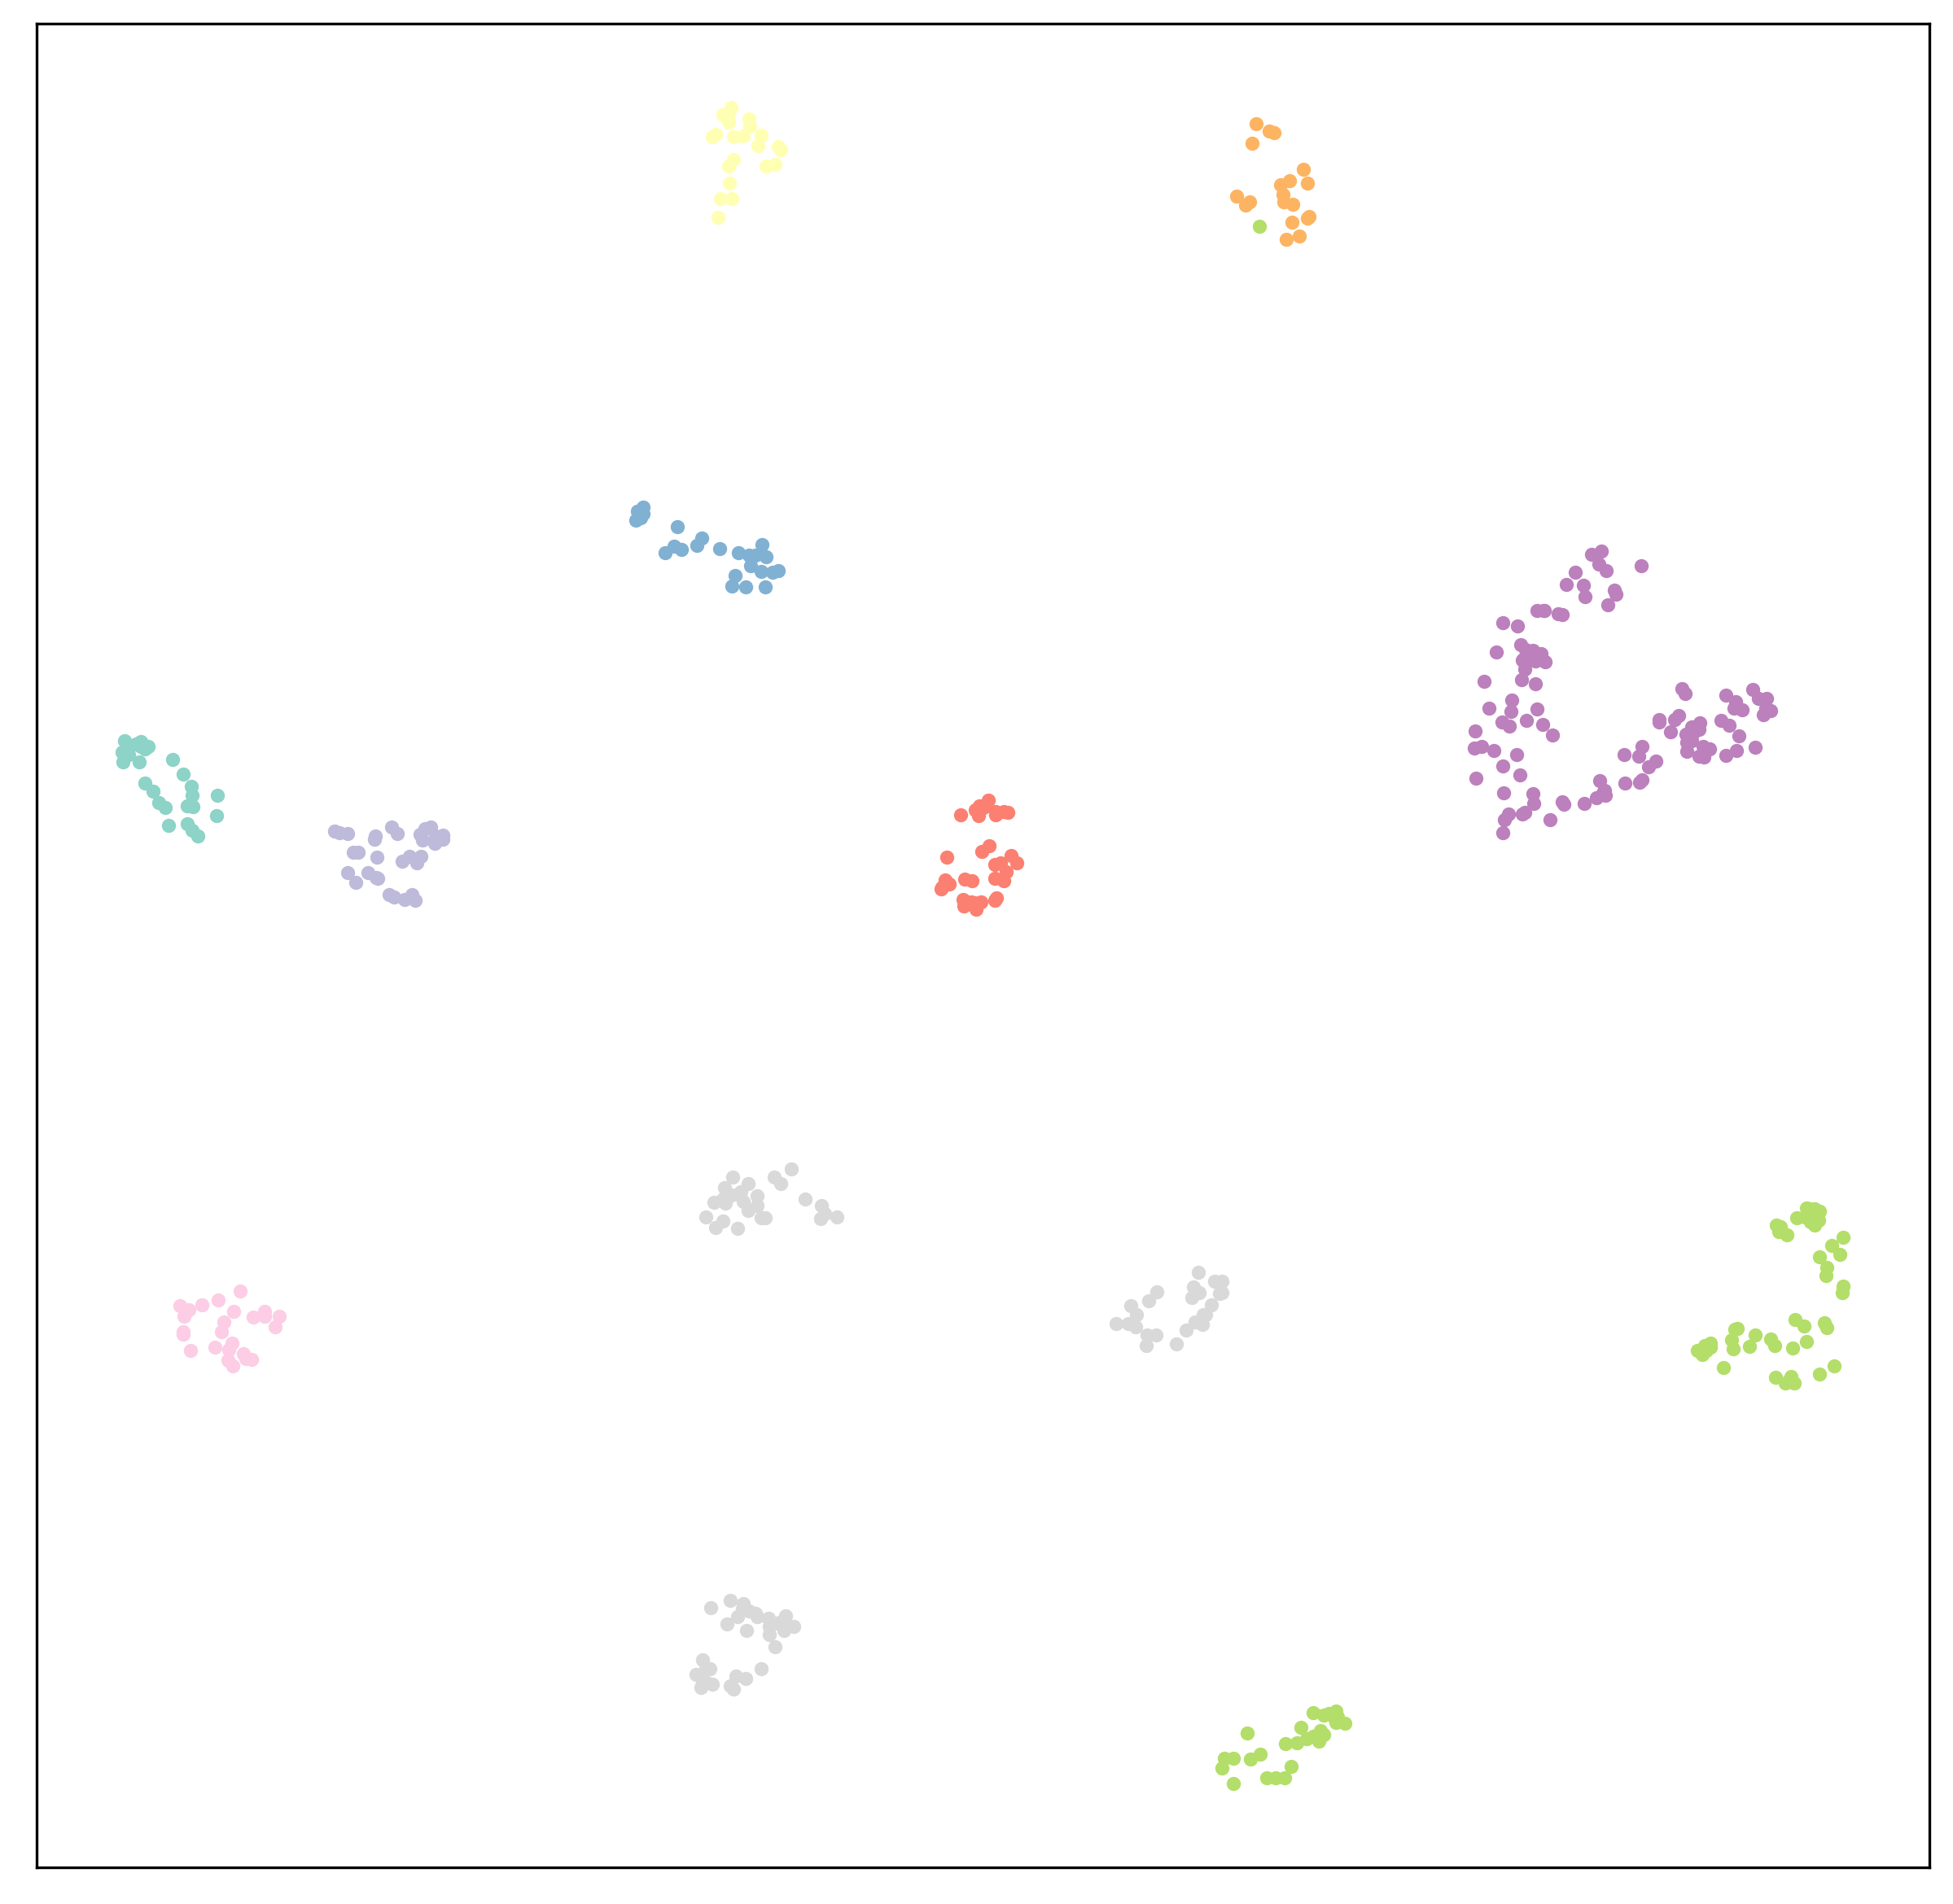

In [56]:
x_min, x_max = tsne_feat.min(0), tsne_feat.max(0)
X_norm = (tsne_feat - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10), dpi=300)
color_set = range(10)
for i in arg_noise:
    plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set3(clean_labels[i]), s=10)
plt.xticks([])
plt.yticks([])
plt.savefig('clean_tsne.png')
plt.savefig('clean_tsne.pdf')
plt.show()